## Work flow
1. Train VGG16 on FER2013 (by Pytorch Lightning)
2. Use the train model for inference (for images, videos, live webcam). For each inference image:
*   Extract facial regions by face_recognition
*   Classify the emotions of the extracted regions



In [ ]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import csv
from PIL import Image

from torchvision import transforms
from torch.utils.data import DataLoader

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')

os.chdir('/content/drive/My Drive/Colab Notebooks/FER2013 PyTorch')

## 1. Data processing


### Load data
https://drive.google.com/file/d/1IiNFgHVamdTyaspQYKp4-c8NFrU9LZkX/view?usp=sharing

In [ ]:
file="fer2013.csv"

train_x,train_y=[],[]
public_test_x, public_test_y=[],[]
private_test_x, private_test_y=[],[]

with open(file,'r') as csvin:
    data=csv.reader(csvin)
    for row in data:
        if row[-1]=="Training":
            temp=[]
            for pixel in row[-2].split( ):
                temp.append(int(pixel))
            train_x.append(temp)
            train_y.append(int(row[0]))

        if row[-1]=="PublicTest":
            temp=[]
            for pixel in row[-2].split( ):
                temp.append(int(pixel))
            public_test_x.append(temp)
            public_test_y.append(int(row[0]))

        if row[-1]=="PrivateTest":
            temp=[]
            for pixel in row[-2].split( ):
                temp.append(int(pixel))
            private_test_x.append(temp)
            private_test_y.append(int(row[0]))

# convert data into numpy arrays
train_x, train_y=np.asarray(train_x), np.asarray(train_y)
public_test_x, public_test_y=np.asarray(public_test_x), np.asarray(public_test_y)
private_test_x, private_test_y=np.asarray(private_test_x), np.asarray(private_test_y)

# reshape the data
train_x=train_x.reshape(-1,48,48)
public_test_x=public_test_x.reshape(-1,48,48)
private_test_x=private_test_x.reshape(-1,48,48)

# print out the shapes of the data
print("Train data      : ", train_x.shape, train_y.shape)
print("Public test data: ", public_test_x.shape, public_test_y.shape)
print("Private test data: ", private_test_x.shape, private_test_y.shape)

Train data      :  (28709, 48, 48) (28709,)
Public test data:  (3589, 48, 48) (3589,)
Private test data:  (3589, 48, 48) (3589,)


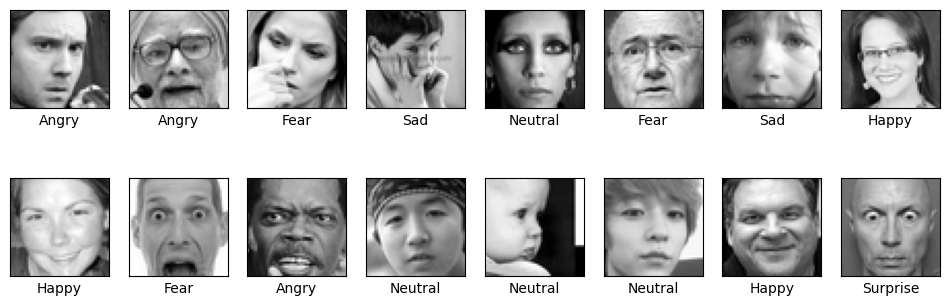

In [ ]:
import matplotlib.pyplot as plt
# display images
images,labels=train_x[:16], train_y[:16]
emotions = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

plt.figure(figsize=(12,4))

for i in range(16):
    plt.subplot(2,8,i+1)
    plt.imshow(images[i],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(emotions[labels[i]])


### Custom dataset with torchvision.transforms

In [ ]:
from torch.utils.data import Dataset

class FER2013(Dataset):
    def __init__(self,split="train",transforms=None,device="mps"):
        super().__init__()
        self.transforms=transforms
        self.split=split
        self.device=device

        if split=="train":
            self.train_x=train_x
            self.train_y=train_y

        elif split=="public":
            self.public_test_x=public_test_x
            self.public_test_y=public_test_y

        elif split=="private":
            self.private_test_x=private_test_x
            self.private_test_y=private_test_y

    def __getitem__(self,idx):
        # return image,label at index idx
        if self.split=="train":
            img,label=self.train_x[idx],self.train_y[idx]
        elif self.split=="public":
            img,label=self.public_test_x[idx],self.public_test_y[idx]
        elif self.split=="private":
            img,label=self.private_test_x[idx],self.private_test_y[idx]

        if self.transforms is not None:
            img=Image.fromarray(img.astype(np.uint8))
            img=self.transforms(img)

        # move to correct device
        img=img.to(self.device)
        label=torch.tensor(label).to(self.device)

        return img,label

    def __len__(self):
        if self.split=="train":
            return len(self.train_y)
        elif self.split=="public":
            return len(self.public_test_y)
        elif self.split=="private":
            return len(self.private_test_y)


In [ ]:
# get data loaders

from torchvision import transforms
from torch.utils.data import DataLoader

cut_size=44
transform_train=transforms.Compose([
    transforms.RandomCrop(cut_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

# for each test image: randomly crop into 10 subimages
#          prediction = average prediction over these 10 subimages
transform_test=transforms.Compose([
    transforms.TenCrop(cut_size),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
])

# loaders
batch_size=128

train_data=FER2013(split="train",transforms=transform_train, device="mps")
train_loader=DataLoader(train_data,batch_size=batch_size,shuffle=True)

val_data=FER2013(split="public",transforms=transform_test, device="mps")
val_loader=DataLoader(val_data,batch_size=batch_size,shuffle=False)

test_data=FER2013(split="private",transforms=transform_test, device="mps")
test_loader=DataLoader(test_data,batch_size=batch_size,shuffle=False)

In [ ]:
# check shape a batch
batch,labels=next(iter(train_loader))
print(f"Train data: {batch.shape} | Label: {labels.shape}")
print(f"num_batches in train_loader: {len(train_loader)}")
print(f"num_batches in val_loader  : {len(val_loader)}")
print(f"num_batches in test_loader : {len(test_loader)}")
print(f"Device: {batch.device}")

Train data: torch.Size([128, 1, 44, 44]) | Label: torch.Size([128])
num_batches in train_loader: 225
num_batches in val_loader  : 29
num_batches in test_loader : 29
Device: mps:0


## 2. Train FER2013 on VGG16 with Pytorch Lightning

### VGG16 from scratch

In [ ]:
import pytorch_lightning
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import torch.nn.functional as F
import torchmetrics

In [ ]:
# VGG16_ORIGINAL=torchvision.models.vgg16()
# VGG16_ORIGINAL

In [ ]:
layers=[64,64,'M',128,128,'M',256,256,256,'M',512,512,512,'M',512,512,512,'M']
device="mps"
torch.manual_seed(1442)

class vgg16(pytorch_lightning.LightningModule):
    def __init__(self,in_channel=1, num_classes=7,dropout=0.5,lr=0.01):
        super().__init__()

        self.in_channel=in_channel
        self.num_classes=num_classes
        self.lr=lr

        self.dropout=nn.Dropout(dropout)

        # VGG16 backbone
        self.backbone=[]
        for layer in layers:
            if layer=='M':
                self.backbone+=[nn.MaxPool2d(kernel_size=2,stride=2)]
            else:
                self.backbone+=[nn.Conv2d(in_channel,layer,kernel_size=3,padding=1),
                                nn.BatchNorm2d(layer),
                                nn.ReLU(inplace=True)]
                in_channel=layer

        self.backbone+=[nn.AdaptiveAvgPool2d((1,1))]
        self.backbone=nn.Sequential(*self.backbone)

        # classifier
        self.classifier=nn.Linear(512,num_classes)

        # acc metrics
        self.acc=torchmetrics.classification.Accuracy(task="multiclass",num_classes=num_classes)

    def training_step(self,batch,batch_idx): # return loss and log in train_loss + train_acc

        x,y=batch

        preds=self.forward(x) # preds = logits
        loss=F.cross_entropy(preds,y)

        self.log("train_loss",loss)
        self.log("train_acc",self.acc(preds,y))

        return loss

    def validation_step(self,batch,batch_idx): # log in val_loss and val_acc
        x,y=batch
        # x=[128,10,1,44,44] -> take average prediction over 10 subimages
        x=x.transpose(0,1) # [10,128,1,44,44]
        loss=0.0
        preds=torch.zeros(x.size(1),self.num_classes,device=device)  # [128,7]
        for i in range(x.size(0)):
            # prediction and loss for subimage i
            preds+=self.forward(x[i])
            loss+=F.cross_entropy(preds,y)
        loss/=x.size(0)
        preds/=x.size(0)
        self.log("val_loss",loss)
        self.log("val_acc",self.acc(preds,y))

    def test_step(self,batch,batch_idx): # log in test_loss and test_acc
        x,y=batch
        # x=[128,10,1,44,44] -> take average prediction over 10 subimages
        x=x.transpose(0,1) # [10,128,1,44,44]
        loss=0.0
        preds=torch.zeros(x.size(1),self.num_classes,device=device)  # [128,7]
        for i in range(x.size(0)):
            # prediction and loss for subimage i
            preds+=self.forward(x[i])
            loss+=F.cross_entropy(preds,y)
        loss/=x.size(0)
        preds/=x.size(0)
        self.log("test_loss",loss)
        self.log("test_acc",self.acc(preds,y))


    def forward(self,x):
        # x= a batch of data = [128,1,44,44]

        # backbone
        x=self.backbone(x)           # [128,512,1,1]
        x=x.squeeze(-1).squeeze(-1)  # [128,512]

        # dropout
        x=self.dropout(x)            # [128,512]
        # classifier
        x=self.classifier(x)         # [128,7]

        return x

    def configure_optimizers(self):

        optimizer=torch.optim.SGD(self.parameters(),lr=self.lr,momentum=0.9,weight_decay=5e-4)
        scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode="min",patience=5,factor=0.1)

        return {"optimizer": optimizer,
                "lr_scheduler": {"scheduler": scheduler,
                                "monitor": "train_loss",
                                "interval": "epoch", # default
                                "frequency": 1       # default
                                }
                }

In [ ]:
# initiate the model
model=vgg16()

trainer=pytorch_lightning.Trainer(accelerator="mps",devices=1, max_epochs=150,
                                  callbacks=[ModelCheckpoint(save_top_k=1,mode="max",monitor="val_acc",save_last=True)]
)

# trainer.fit(model,train_loader,val_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


## 3. Deploy the model

In [ ]:
# load model from checkpoint
# path=trainer.checkpoint_callback.best_model_path
ckpt_path="epoch=135-step=30600.ckpt" # the path saved in my local computer
model=vgg16.load_from_checkpoint(ckpt_path)

# inference on test set
trainer.test(model,test_loader)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Testing: |                                                | 0/? [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchmetrics/functional/classification/accuracy.py:77: UserWarning: MPS: no support for int64 reduction ops, casting it to int32 (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/ReduceOps.mm:144.)
  tp = tp.sum(dim=0 if multidim_average == "global" else 1)


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7157982587814331
        test_loss            7.599438190460205
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 7.599438190460205, 'test_acc': 0.7157982587814331}]

In [ ]:
emotions = {
    0: ['Angry', (0,0,255), (255,255,255)],
    1: ['Disgust', (0,102,0), (255,255,255)],
    2: ['Fear', (255,255,153), (0,51,51)],
    3: ['Happy', (153,0,153), (255,255,255)],
    4: ['Sad', (255,0,0), (255,255,255)],
    5: ['Surprise', (0,255,0), (255,255,255)],
    6: ['Neutral', (160,160,160), (255,255,255)]
}

### Inference on image
1. Use API face_recognition to extract facial regions in an image
2. Use the model to classify emotions from these extracted regions

In [ ]:
import cv2
import face_recognition

@torch.no_grad()
def inference_image(model,image):
    # image = cv2 image
    model.eval()
    locations=face_recognition.face_locations(image)
    for (top,right,bottom,left) in locations:
        face=image[top:bottom, left:right,:]            # [W,H,3]
        # convert to gray scale
        face_gray=cv2.cvtColor(face,cv2.COLOR_BGR2GRAY) # [W,H]
        face_gray=cv2.resize(face_gray,(48,48))         # [48,48]
        face_gray=transform_test(Image.fromarray(face_gray)) # [10,1,44,44]

        pred=model(face_gray)                           # [10,7]
        pred=pred.mean(axis=0)                          # [7,]
        pred=pred.argmax().item()

        # draw retangular and put text
        cv2.rectangle(image,(left,top),(right,bottom), emotions[pred][1],2)
        cv2.rectangle(image,(left,top-30), (right,top), emotions[pred][1],-1)
        cv2.putText(image,f'{emotions[pred][0]}', (left,top-5),0,0.7,emotions[pred][2],2)
    # cv2.imwrite(image_path,image)
    return image

In [ ]:
# inference on image
image=cv2.imread("inference/images/digipen.jpeg")
out=inference_image(model,image)
cv2.imwrite("inference/images/out.png",out)

True

### Inference on video


In [ ]:
def inference_video(model,path):
    # path = path to the video
    cap=cv2.VideoCapture(path)
    width,height=int(cap.get(3)), int(cap.get(4))
    fps=cap.get(cv2.CAP_PROP_FPS)
    num_frames=int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # create a codec to write new video
    out=cv2.VideoWriter(path[:-4]+"_out.mp4",
                       cv2.VideoWriter_fourcc(*"mp4v"),fps,(width,height))
    # read frame, make inference and write into a video
    while True:
        success,image=cap.read()
        if success:
            image=inference_image(model,image)
            out.write(image)
        else:
            break
    cap.release()
    out.release()
    cv2.destroyAllWindows()

In [ ]:
import moviepy
from moviepy.editor import *

# combine video and audio
def combine_video_audio(path):
    # pathe of original video clip
    processed_path=path[:-4]+"_out.mp4"
    # extract the clip
    clip=VideoFileClip(processed_path)
    # extract audio file from the original clip
    audio=moviepy.editor.VideoFileClip(path).audio
    # set audio for clip
    videoclip=clip.set_audio(audio)

    # new file name and write a new video with audio
    new_name=path[:-4]+"with_audio_out.mp4"

    videoclip.write_videofile(new_name, codec='libx264', audio_codec='aac',remove_temp=True)


In [ ]:
from timeit import default_timer as timer

path="inference/videos/musk-ma.mp4"

cap2=cv2.VideoCapture(path)
num_frames=int(cap2.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"{num_frames} frames")

print("Converting....")
start_time=timer()
inference_video(model,path)
combine_video_audio(path)
end_time=timer()

print(f"Conversion done in {(end_time-start_time)/60:.2f} minutes")

### Inference on live camera

In [ ]:
@torch.no_grad()
def prediction(model,face): # face = face image
    model.eval()
    # convert to gray-scale and resize it to (48,48)
    gray=cv2.cvtColor(face,cv2.COLOR_BGR2GRAY)
    gray=cv2.resize(gray,(48,48)).astype(np.uint8)

    # randomly crop the face image into 10 subimages
    inputs=transform_test(Image.fromarray(gray))      #[10,1,44,44]

    pred=model(inputs)                                # [10,7]
    pred=pred.mean(axis=0)                            # [7,]
    return pred.argmax().item()

In [ ]:

# load webcam
cap=cv2.VideoCapture(0)
process_this_frame=True # only process every 2nd frame for faster inference

while True:
    # read frames
    success,frame=cap.read()
    if process_this_frame:
        # resize 1/4 of original frame for faster inference
        small_frame=cv2.resize(frame,(0,0),fx=0.25,fy=0.25)
        face_locations=face_recognition.face_locations(small_frame)

    process_this_frame=not process_this_frame

    # give predictions to facial regions and display results
    for (top,right,bottom,left) in face_locations:

        face=small_frame[top:bottom,left:right,:]
        pred=prediction(model,face)

        # scale back up face locations to draw boxes
        top, right, bottom, left=top*4, right*4, bottom*4, left*4

        # draw rectangle and put texts around the faces
        cv2.rectangle(frame,(left,top), (right,bottom),emotions[pred][1],2)
        cv2.rectangle(frame,(left,top-50), (right,top),emotions[pred][1],-1)
        cv2.putText(frame,f'{emotions[pred][0]}', (left,top-5),0,1.5,emotions[pred][2],2)

    # show frame
    cv2.imshow("Frame",frame)

    # set up an escape key
    key=cv2.waitKey(1)

    if key==27: #escape key
        break


2024-06-20 15:58:15.814 Python[81562:3199357] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
